<a href="https://colab.research.google.com/github/hayya54/Analisis-Faktor-Demografi-Terhadap-Tingkat-Pembenaran-Berbasis-Gender/blob/main/Model_fix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Analisis Faktor Demografi Terhadap Tingkat Pembenaran Kekerasan Seksual Berbasis Gender Menggunakan Pendekatan Hybrid BERT-LightGBM**

# 1. Import Library

In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import random

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.decomposition import PCA
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score
)

# NLP - BERT
import torch
from transformers import BertTokenizer, BertModel, logging as transformers_logging

# Machine Learning - LightGBM
import lightgbm as lgb

# SHAP for interpretability
import shap

# Statistical tests
from scipy import stats
from scipy.stats import ttest_ind, levene

# Utils
import joblib
from tqdm import tqdm
import time
import os
from datetime import datetime
import json

# Suppress BERT warnings
transformers_logging.set_verbosity_error()

# Set plotting style
sns.set(style="whitegrid")
plt.rcParams['figure.dpi'] = 100

print("=" * 80)
print("MODEL HYBRID BERT-LIGHTGBM v3.0 (PRODUCTION-READY)")
print("=" * 80)
print(f"✅ Semua library berhasil diimpor")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 80)

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print(f"\n🔒 Reproducibility seed set: {SEED}")

MODEL HYBRID BERT-LIGHTGBM v3.0 (PRODUCTION-READY)
✅ Semua library berhasil diimpor
PyTorch version: 2.9.0+cpu
CUDA available: False
Generated: 2026-02-10 00:51:10

🔒 Reproducibility seed set: 42


# 2. LOAD DATA

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Skripsi_Fix/Violence Against Women  Girls Data.csv")

In [ ]:
print(f"\n📊 Dataset shape: {df.shape}")
print(f"   Jumlah baris: {df.shape[0]:,}")
print(f"   Jumlah kolom: {df.shape[1]}")
print(f"\n📋 Kolom yang tersedia:")
for i, col in enumerate(df.columns.tolist(), 1):
    print(f"   {i:2d}. {col}")


📊 Dataset shape: (12600, 8)
   Jumlah baris: 12,600
   Jumlah kolom: 8

📋 Kolom yang tersedia:
    1. RecordID
    2. Country
    3. Gender
    4. Demographics Question
    5. Demographics Response
    6. Question
    7. Survey Year
    8. Value


In [ ]:
df.head(5)

,RecordID,Country,Gender,Demographics Question,Demographics Response,Question,Survey Year,Value
0,1,Afghanistan,F,Marital status,Never married,... if she burns the food,01/01/2015,NaN
1,1,Afghanistan,F,Education,Higher,... if she burns the food,01/01/2015,10.1
2,1,Afghanistan,F,Education,Secondary,... if she burns the food,01/01/2015,13.7
3,1,Afghanistan,F,Education,Primary,... if she burns the food,01/01/2015,13.8
4,1,Afghanistan,F,Marital status,"Widowed, divorced, separated",... if she burns the food,01/01/2015,13.8


## 2.1 Data Cleaning - Normalisasi Gender

In [ ]:
print("\n🔧 Normalisasi label Gender...")
df['Gender'] = df['Gender'].astype(str).str.strip().str.lower()
gender_map = {
    'm': 'Male', 'male': 'Male',
    'f': 'Female', 'female': 'Female'
}
df['Gender'] = df['Gender'].map(gender_map).fillna(df['Gender'].str.title())
print(f"✅ Gender normalization complete")
print(df['Gender'].value_counts(dropna=False))


🔧 Normalisasi label Gender...
✅ Gender normalization complete
Gender
Female    6300
Male      6300
Name: count, dtype: int64


# 3. EXPLORATORY DATA ANALYSIS (EDA)

## 3.1 Dataset Info

In [ ]:
print(df.info())

print("\n--- 3.2 Missing Values ---")
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({
    'Jumlah Missing': missing_data,
    'Persentase (%)': missing_percent
})
print(missing_df[missing_df['Jumlah Missing'] > 0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12600 entries, 0 to 12599
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   RecordID               12600 non-null  int64  
 1   Country                12600 non-null  object 
 2   Gender                 12600 non-null  object 
 3   Demographics Question  12600 non-null  object 
 4   Demographics Response  12600 non-null  object 
 5   Question               12600 non-null  object 
 6   Survey Year            12600 non-null  object 
 7   Value                  11187 non-null  float64
dtypes: float64(1), int64(1), object(6)
memory usage: 787.6+ KB
None

--- 3.2 Missing Values ---
       Jumlah Missing  Persentase (%)
Value            1413       11.214286


## 3.2 Missing Values

In [ ]:
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({
    'Jumlah Missing': missing_data,
    'Persentase (%)': missing_percent
})
print(missing_df[missing_df['Jumlah Missing'] > 0])

       Jumlah Missing  Persentase (%)
Value            1413       11.214286


## 3.3 Statistik Deskriptif Target Variable (Value)

In [ ]:
print(df['Value'].describe())

count    11187.000000
mean        19.762537
std         16.986437
min          0.000000
25%          6.200000
50%         14.900000
75%         29.200000
max         86.900000
Name: Value, dtype: float64


## 3.4 Klasifikasi berdasarkan Indikator (Question)

In [ ]:
print(df['Question'].value_counts())

Question
... if she burns the food                  2100
... for at least one specific reason       2100
... if she argues with him                 2100
... if she goes out without telling him    2100
... if she neglects the children           2100
... if she refuses to have sex with him    2100
Name: count, dtype: int64


## 3.5 Distribusi Gender

In [ ]:
print(df['Gender'].value_counts())

Gender
Female    6300
Male      6300
Name: count, dtype: int64


# 4. VISUALISASI DATA

## 4.1 Distribusi Target Variable

✅ Saved: 01_distribusi_target.png
   Skewness: 1.079
   Kurtosis: 0.573


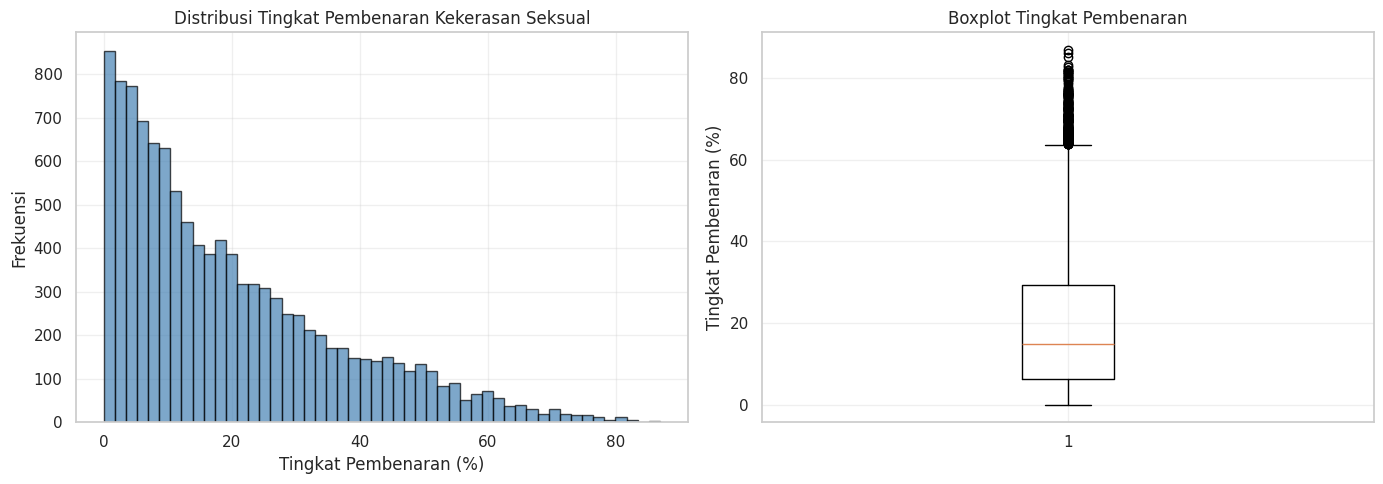

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df['Value'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_xlabel('Tingkat Pembenaran (%)')
axes[0].set_ylabel('Frekuensi')
axes[0].set_title('Distribusi Tingkat Pembenaran Kekerasan Seksual')
axes[0].grid(True, alpha=0.3)

axes[1].boxplot(df['Value'].dropna())
axes[1].set_ylabel('Tingkat Pembenaran (%)')
axes[1].set_title('Boxplot Tingkat Pembenaran')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('01_distribusi_target.png', dpi=300, bbox_inches='tight')
print("✅ Saved: 01_distribusi_target.png")

print(f"   Skewness: {df['Value'].skew():.3f}")
print(f"   Kurtosis: {df['Value'].kurtosis():.3f}")

## 4.2 Pembenaran Berdasarkan Gender

✅ Saved: 02_gender_distribution.png


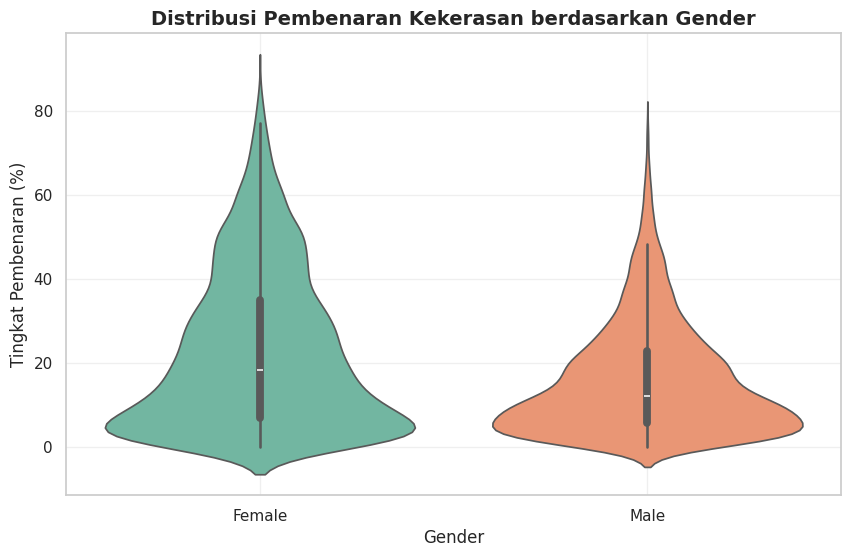

In [ ]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='Gender', y='Value', data=df, palette='Set2')
plt.title('Distribusi Pembenaran Kekerasan berdasarkan Gender', fontsize=14, fontweight='bold')
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Tingkat Pembenaran (%)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.savefig('02_gender_distribution.png', dpi=300, bbox_inches='tight')
print("✅ Saved: 02_gender_distribution.png")

In [ ]:
# Statistical test: Gender
male_values = df[df['Gender'] == 'Male']['Value'].dropna()
female_values = df[df['Gender'] == 'Female']['Value'].dropna()

if len(male_values) > 0 and len(female_values) > 0:
    t_stat, p_value = stats.ttest_ind(male_values, female_values, nan_policy='omit')
    print(f"\n📊 T-test Gender: t={t_stat:.4f}, p-value={p_value:.4e}")
    print(f"   Mean Male: {male_values.mean():.2f}%")
    print(f"   Mean Female: {female_values.mean():.2f}%")


📊 T-test Gender: t=-22.2872, p-value=1.0667e-107
   Mean Male: 15.90%
   Mean Female: 22.94%


## 4.3 Pembenaran Berdasarkan Demographics Question

✅ Saved: 03_demographics_question.png


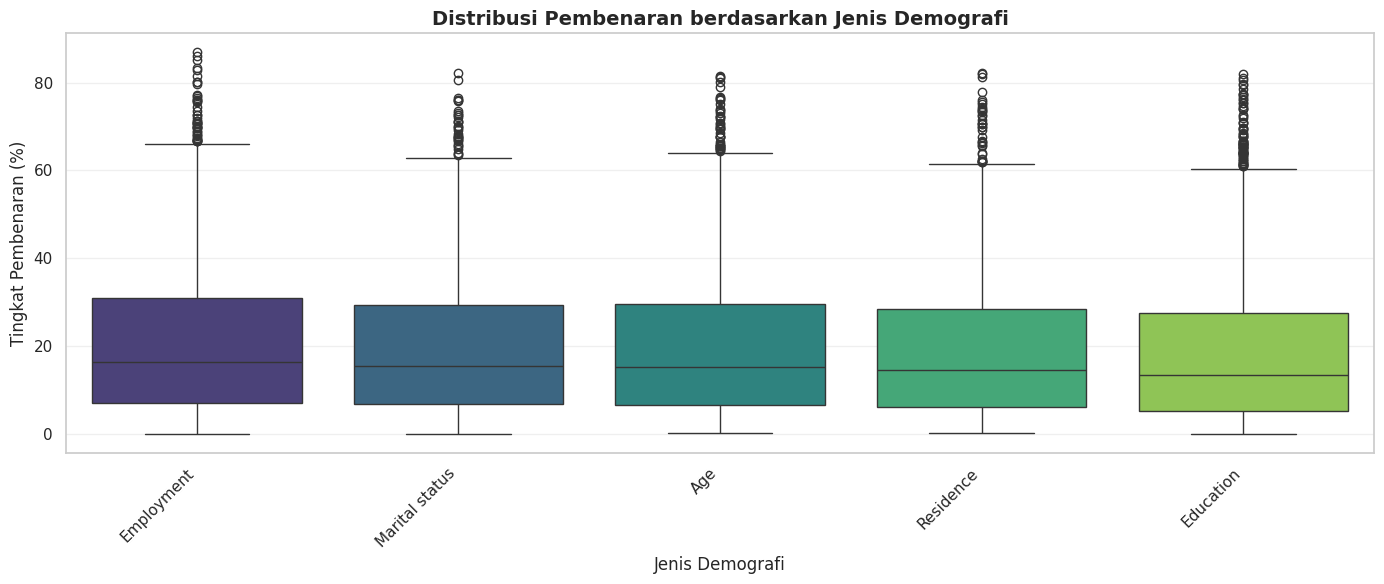

In [ ]:
plt.figure(figsize=(14, 6))
demo_order = df.groupby('Demographics Question')['Value'].median().sort_values(ascending=False).index
sns.boxplot(x='Demographics Question', y='Value', data=df, order=demo_order, palette='viridis')
plt.title('Distribusi Pembenaran berdasarkan Jenis Demografi', fontsize=14, fontweight='bold')
plt.xlabel('Jenis Demografi', fontsize=12)
plt.ylabel('Tingkat Pembenaran (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('03_demographics_question.png', dpi=300, bbox_inches='tight')
print("✅ Saved: 03_demographics_question.png")

## 4.4 Top 15 Countries

✅ Saved: 04_top_countries.png


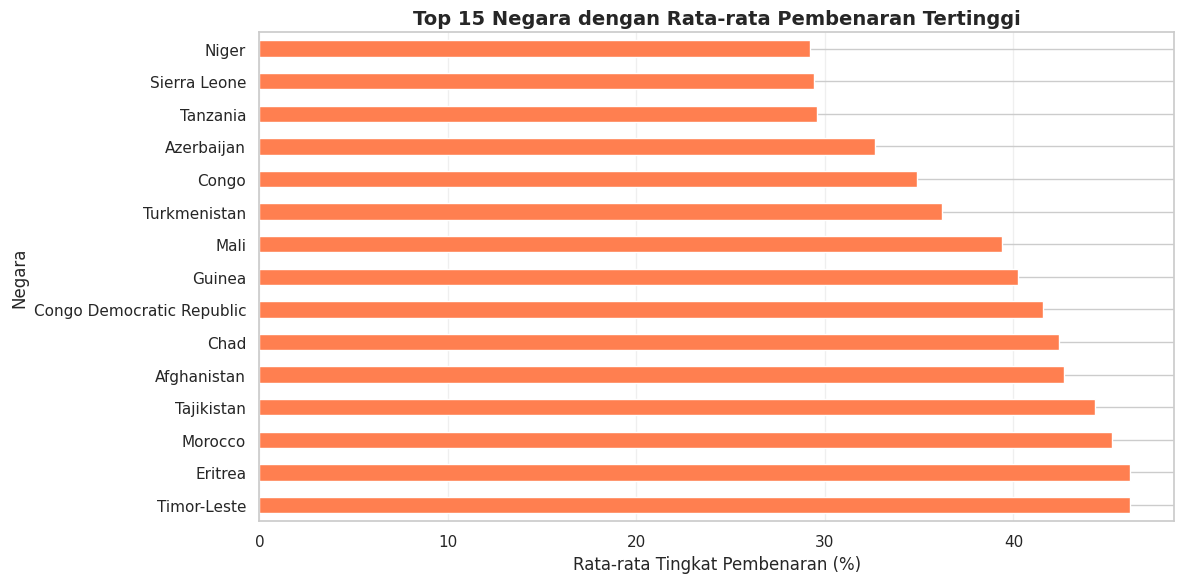

In [ ]:
top_countries = df.groupby('Country')['Value'].mean().sort_values(ascending=False).head(15)

plt.figure(figsize=(12, 6))
top_countries.plot(kind='barh', color='coral')
plt.title('Top 15 Negara dengan Rata-rata Pembenaran Tertinggi', fontsize=14, fontweight='bold')
plt.xlabel('Rata-rata Tingkat Pembenaran (%)', fontsize=12)
plt.ylabel('Negara', fontsize=12)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('04_top_countries.png', dpi=300, bbox_inches='tight')
print("✅ Saved: 04_top_countries.png")

## 4.5 Tren Survey Year

✅ Saved: 05_yearly_trend.png


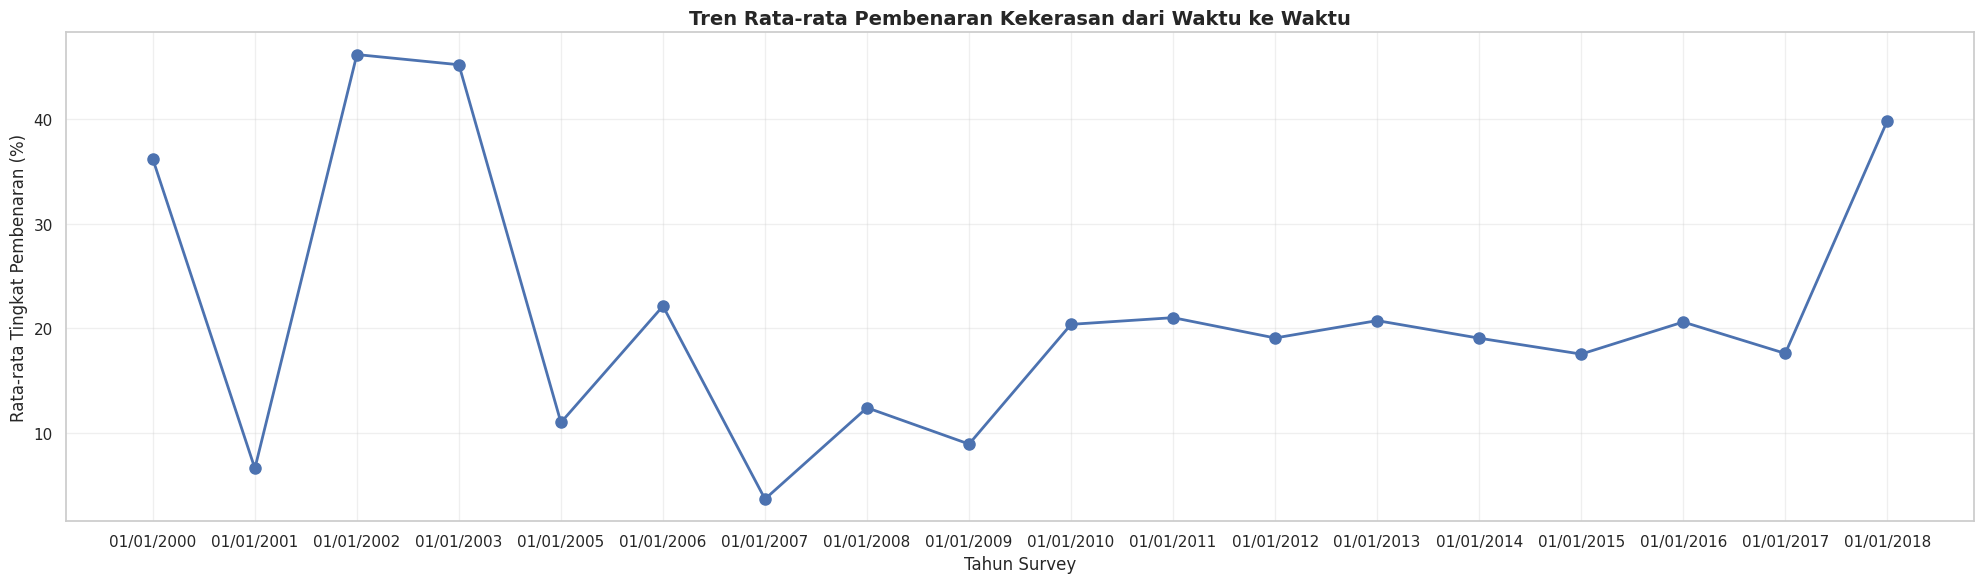

In [ ]:
plt.figure(figsize=(20, 6))
yearly_avg = df.groupby('Survey Year')['Value'].mean().sort_index()
plt.plot(yearly_avg.index, yearly_avg.values, marker='o', linewidth=2, markersize=8)
plt.title('Tren Rata-rata Pembenaran Kekerasan dari Waktu ke Waktu', fontsize=14, fontweight='bold')
plt.xlabel('Tahun Survey', fontsize=12)
plt.ylabel('Rata-rata Tingkat Pembenaran (%)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('05_yearly_trend.png', dpi=300, bbox_inches='tight')
print("✅ Saved: 05_yearly_trend.png")

## 4.6 Heatmap Korelasi

✅ Saved: 06_correlation_matrix.png


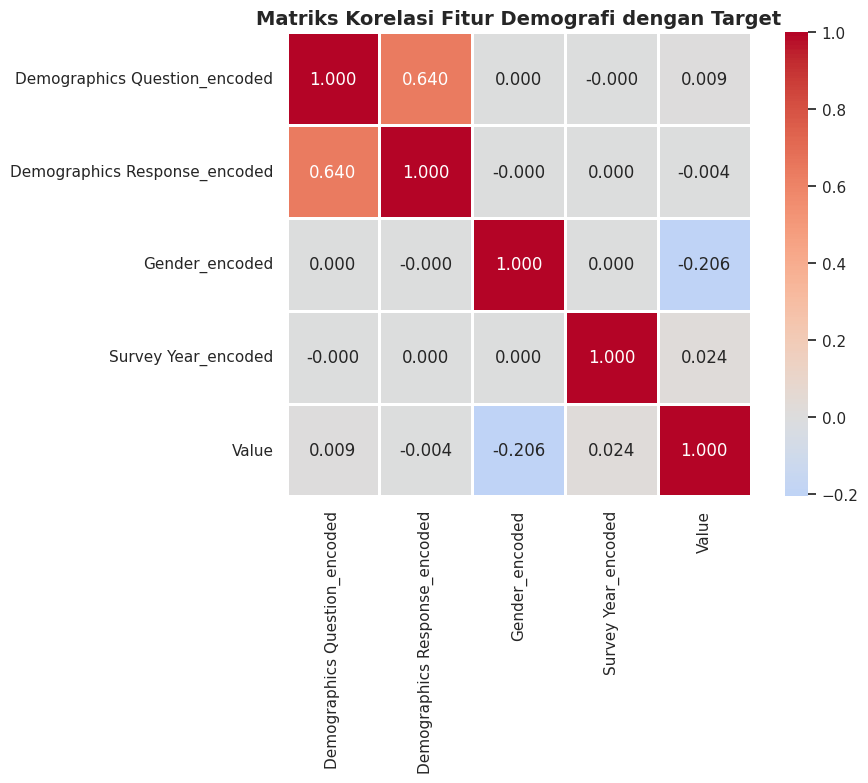

In [ ]:
df_temp = df.copy()
for col in ['Demographics Question', 'Demographics Response', 'Gender', 'Survey Year']:
    le = LabelEncoder()
    df_temp[col + '_encoded'] = le.fit_transform(df_temp[col].astype(str))

corr_cols = ['Demographics Question_encoded', 'Demographics Response_encoded',
             'Gender_encoded', 'Survey Year_encoded', 'Value']
correlation_matrix = df_temp[corr_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            fmt='.3f', linewidths=1, square=True)
plt.title('Matriks Korelasi Fitur Demografi dengan Target', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('06_correlation_matrix.png', dpi=300, bbox_inches='tight')
print("✅ Saved: 06_correlation_matrix.png")

# 5. PREPROCESSING

## 5.1 Handle Missing Values

In [ ]:
df_model = df.dropna(subset=['Value', 'Country', 'Gender', 'Question',
                              'Demographics Question', 'Demographics Response'])
df_model_clean = df_model[df_model['Value'] >= 0].copy()

print(f" Data setelah cleaning: {df_model_clean.shape[0]:,} baris")

 Data setelah cleaning: 11,187 baris


## 5.2 Extract Survey Year

In [ ]:
df_model_clean['Survey_Year'] = pd.to_datetime(df_model_clean['Survey Year'],
                                                 errors='coerce').dt.year

## 5.3 Target Variable

In [ ]:
y = df_model_clean['Value'].values
print(f"   Target variable shape: {y.shape}")

   Target variable shape: (11187,)


## 5.4 Categorical Features (DEMOGRAPHIC FEATURES)

In [ ]:
cat_cols = ['Country', 'Gender', 'Demographics Question', 'Demographics Response', 'Survey_Year']

## 5.5 Label Encoding untuk Fitur Kategorikal

In [ ]:
X_cat = df_model_clean[cat_cols].copy()
encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    X_cat[col] = le.fit_transform(X_cat[col].astype(str))
    encoders[col] = le

X_demo_all = X_cat.values
y_all = df_model_clean['Value'].values

# 6. EKSTRAKSI FITUR BERT (TEXT EMBEDDINGS)

In [ ]:
"""
IMPORTANT CLARIFICATION:
========================
Kolom 'Question' berisi pertanyaan tentang PEMBENARAN KEKERASAN yang
di-encode menggunakan BERT untuk mengekstrak makna semantik.

Contoh isi kolom 'Question':
- "Percentage of women age 15-49 who agree that a husband is justified
   in hitting or beating his wife for at least one specific reason"

Faktor demografi (Gender, Country, Demographics Question, dll.)
di-encode menggunakan LabelEncoder karena bersifat kategorikal.

Ini adalah HYBRID approach: Demographics (5 fitur) + BERT Embeddings (768 fitur)
"""
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"  Device: {device}")

  Device: cpu


## 6.1 Load BERT Model

In [ ]:
BERT_MODEL = 'bert-base-uncased'
print(f" Loading BERT model ({BERT_MODEL})...")

tokenizer = BertTokenizer.from_pretrained(BERT_MODEL)
bert_model = BertModel.from_pretrained(BERT_MODEL).to(device)
bert_model.eval()

print(f" BERT model loaded on: {device}")

 Loading BERT model (bert-base-uncased)...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

 BERT model loaded on: cpu


In [ ]:
# Save tokenizer untuk reproducibility
tokenizer.save_pretrained('bert_tokenizer_v3')
print("✅ Tokenizer saved to 'bert_tokenizer_v3/'")

✅ Tokenizer saved to 'bert_tokenizer_v3/'


## 6.2 Fungsi Ekstraksi Embedding BERT

In [ ]:
def get_bert_embeddings(text_list, model, tokenizer, device, batch_size=32):
    """
    Extract BERT CLS embeddings from text list

    Args:
        text_list: List of text strings
        model: BERT model
        tokenizer: BERT tokenizer
        device: torch device
        batch_size: Batch size for inference

    Returns:
        numpy array of shape (n_samples, 768) containing CLS embeddings
    """
    model.eval()
    embeddings = []

    for i in tqdm(range(0, len(text_list), batch_size), desc="Extracting BERT embeddings"):
        batch_text = text_list[i:i+batch_size]

        # Tokenize
        encoded = tokenizer(
            batch_text,
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors='pt'
        ).to(device)

        # Inference
        with torch.no_grad():
            outputs = model(**encoded)
            # Use CLS token (index 0) as sentence representation
            cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings.append(cls_embeddings)

    return np.vstack(embeddings)

## 6.3 Ekstrak Fitur dari Kolom Question

In [ ]:
print("\n Extracting BERT Embeddings from 'Question' column...")
questions = df_model_clean['Question'].tolist()
X_text = get_bert_embeddings(questions, bert_model, tokenizer, device)

print(f" Shape text embeddings (BERT): {X_text.shape}")

# Save raw embeddings
try:
    np.save('bert_embeddings_raw_v3.npy', X_text)
    print("✅ Saved raw BERT embeddings to 'bert_embeddings_raw_v3.npy'")
except Exception as e:
    print(f"⚠️  Failed to save raw embeddings: {e}")


 Extracting BERT Embeddings from 'Question' column...


Extracting BERT embeddings: 100%|██████████| 350/350 [07:48<00:00,  1.34s/it]

 Shape text embeddings (BERT): (11187, 768)
✅ Saved raw BERT embeddings to 'bert_embeddings_raw_v3.npy'


# 7. TRAIN-TEST SPLIT

In [ ]:
TEST_SIZE = 0.2

stratify_var = None
if df_model_clean['Gender'].nunique() > 1:
    stratify_var = df_model_clean['Gender'].values

X_demo_train, X_demo_test, \
X_text_train, X_text_test, \
y_train, y_test, \
idx_train, idx_test = train_test_split(
    X_demo_all,
    X_text,
    y_all,
    np.arange(len(y_all)),
    test_size=TEST_SIZE,
    random_state=SEED,
    stratify=stratify_var
)

print("✅ Split done BEFORE scaler & PCA")

✅ Split done BEFORE scaler & PCA


## 7.1 SCALER — TRAIN ONLY

In [ ]:
# ===== SCALER — TRAIN ONLY =====
scaler = StandardScaler()
X_demo_train_scaled = scaler.fit_transform(X_demo_train)
X_demo_test_scaled  = scaler.transform(X_demo_test)

print("✅ Scaler fit hanya di TRAIN")

✅ Scaler fit hanya di TRAIN


# 8. DIMENSIONALITY REDUCTION (PCA untuk BERT)

In [ ]:
PCA_DIM = 128

if X_text_train.shape[1] > PCA_DIM:

    pca = PCA(n_components=PCA_DIM, random_state=SEED)

    X_text_train_pca = pca.fit_transform(X_text_train)
    X_text_test_pca  = pca.transform(X_text_test)

    explained_var = np.sum(pca.explained_variance_ratio_)

    print("✅ PCA fit hanya di TRAIN")
    print(f"Explained variance: {explained_var:.4f}")

    joblib.dump(pca, 'pca_v3.pkl')

else:
    X_text_train_pca = X_text_train
    X_text_test_pca  = X_text_test

✅ PCA fit hanya di TRAIN
Explained variance: 1.0000


# 9. COMBINE FEATURES (HYBRID APPROACH)

In [ ]:
# ===== HYBRID FEATURES =====

X_train_hybrid = np.hstack((X_demo_train_scaled, X_text_train_pca))
X_test_hybrid  = np.hstack((X_demo_test_scaled,  X_text_test_pca))

print("✅ Hybrid features ready")
print("Train shape:", X_train_hybrid.shape)
print("Test shape :", X_test_hybrid.shape)


✅ Hybrid features ready
Train shape: (8949, 133)
Test shape : (2238, 133)


In [ ]:
# Combine Scaled Demographic Features with PCA Text Features
print(f"   Feature Breakdown:")
print(f"   Demographic features: {X_demo_train_scaled.shape[1]} (scaled)")
print(f"   BERT embeddings (PCA): {X_text_train_pca.shape[1]} (reduced from 768)")
print(f"   Total hybrid features: {X_train_hybrid.shape[1]}")
print(f"   Total samples: {len(y_all):,}")

   Feature Breakdown:
   Demographic features: 5 (scaled)
   BERT embeddings (PCA): 128 (reduced from 768)
   Total hybrid features: 133
   Total samples: 11,187


In [ ]:
print(f" Split complete:")
print(f"   Train set size: {len(X_train_hybrid):,} ({(1-TEST_SIZE)*100:.0f}%)")
print(f"   Test set size: {len(X_test_hybrid):,} ({TEST_SIZE*100:.0f}%)")

print(f" Target statistics:")
print(f"   Train - Mean: {y_train.mean():.2f}% | Std: {y_train.std():.2f}%")
print(f"   Test  - Mean: {y_test.mean():.2f}% | Std: {y_test.std():.2f}%")

 Split complete:
   Train set size: 8,949 (80%)
   Test set size: 2,238 (20%)
 Target statistics:
   Train - Mean: 19.83% | Std: 17.12%
   Test  - Mean: 19.51% | Std: 16.44%


# 10. HYPERPARAMETER JUSTIFICATION & MODEL SETUP

In [ ]:
"""
HYPERPARAMETER SELECTION RATIONALE:
====================================

Model Demografi & Teks (Baseline):
  - n_estimators: 300 (balanced untuk menghindari overfitting)
  - learning_rate: 0.05 (moderate learning, standard practice)
  - max_depth: 6 (tree depth limitation untuk regularization)
  - num_leaves: 31 (default LightGBM, balanced complexity)
  - subsample: 0.8 (80% data per iteration, prevent overfitting)
  - colsample_bytree: 0.8 (80% features per tree, feature sampling)

Model Hybrid (UTAMA):
  - n_estimators: 400 (lebih banyak untuk memanfaatkan fitur lengkap)
  - learning_rate: 0.05 (sama dengan baseline untuk fair comparison)
  - max_depth: 7 (sedikit lebih dalam untuk feature interaction)
  - num_leaves: 40 (lebih kompleks untuk hybrid features)
  - reg_alpha: 0.1 (L1 regularization untuk feature selection)
  - reg_lambda: 0.1 (L2 regularization untuk smoothing)
  - subsample: 0.8
  - colsample_bytree: 0.8

MATHEMATICAL FORMULATION (LightGBM):
=====================================

1. Objective Function:
   L = Σ l(yᵢ, ŷᵢ) + Σ Ω(fₜ)

   where:
   - l(yᵢ, ŷᵢ) = loss function (MSE untuk regression)
   - Ω(fₜ) = γT + ½λΣwⱼ² + α Σ|wⱼ|
   - T = number of leaves
   - wⱼ = leaf weights
   - γ, λ, α = regularization parameters

2. Split Gain (Gradient-based Tree Learning):
   Gain = ½[G²L/(HL+λ) + G²R/(HR+λ) - (GL+GR)²/(HL+HR+λ)] - γ

   where:
   - GL, GR = sum of gradients (left, right)
   - HL, HR = sum of hessians (left, right)
   - λ = L2 regularization (reg_lambda)
   - γ = minimum gain to split (controlled by min_child_samples)

LIMITATION:
===========
Hyperparameter selection dilakukan melalui manual tuning berdasarkan
best practices dan literature review, bukan systematic grid search.

Untuk penelitian yang lebih rigorous, pertimbangkan GridSearchCV atau
Bayesian Optimization (mis. Optuna).
"""

'\nHYPERPARAMETER SELECTION RATIONALE:\n====================================\n\nModel Demografi & Teks (Baseline):\n  - n_estimators: 300 (balanced untuk menghindari overfitting)\n  - learning_rate: 0.05 (moderate learning, standard practice)\n  - max_depth: 6 (tree depth limitation untuk regularization)\n  - num_leaves: 31 (default LightGBM, balanced complexity)\n  - subsample: 0.8 (80% data per iteration, prevent overfitting)\n  - colsample_bytree: 0.8 (80% features per tree, feature sampling)\n\nModel Hybrid (UTAMA):\n  - n_estimators: 400 (lebih banyak untuk memanfaatkan fitur lengkap)\n  - learning_rate: 0.05 (sama dengan baseline untuk fair comparison)\n  - max_depth: 7 (sedikit lebih dalam untuk feature interaction)\n  - num_leaves: 40 (lebih kompleks untuk hybrid features)\n  - reg_alpha: 0.1 (L1 regularization untuk feature selection)\n  - reg_lambda: 0.1 (L2 regularization untuk smoothing)\n  - subsample: 0.8\n  - colsample_bytree: 0.8\n\nMATHEMATICAL FORMULATION (LightGBM):\

In [ ]:
params_demo = {
    'n_estimators': 300,
    'learning_rate': 0.05,
    'max_depth': 6,
    'num_leaves': 31,
    'min_child_samples': 20,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': SEED,
    'verbose': -1
}

In [ ]:
params_text = {
    'n_estimators': 300,
    'learning_rate': 0.05,
    'max_depth': 6,
    'num_leaves': 31,
    'min_child_samples': 20,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': SEED,
    'verbose': -1
}

In [ ]:
params_hybrid = {
    'n_estimators': 400,
    'learning_rate': 0.05,
    'max_depth': 7,
    'num_leaves': 40,
    'min_child_samples': 20,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,  # L1 regularization
    'reg_lambda': 0.1,  # L2 regularization
    'random_state': SEED,
    'verbose': -1
}

# 11. MODEL TRAINING - BASELINE (DEMOGRAFI)

In [ ]:
print(" Hyperparameter Model Demografi:")
for key, val in params_demo.items():
    print(f"   {key}: {val}")

lgb_demo = lgb.LGBMRegressor(**params_demo)

print("  Training Model Demografi...")
start_time = time.time()
lgb_demo.fit(X_demo_train_scaled, y_train)
train_time_demo = time.time() - start_time

y_pred_demo_train = lgb_demo.predict(X_demo_train_scaled)
y_pred_demo_test = lgb_demo.predict(X_demo_test_scaled)

print(f" Training complete in {train_time_demo:.2f} seconds")

 Hyperparameter Model Demografi:
   n_estimators: 300
   learning_rate: 0.05
   max_depth: 6
   num_leaves: 31
   min_child_samples: 20
   subsample: 0.8
   colsample_bytree: 0.8
   random_state: 42
   verbose: -1
  Training Model Demografi...
 Training complete in 1.19 seconds


# 12. MODEL TRAINING - BASELINE (TEKS/BERT)

In [ ]:
print(" Hyperparameter Model Teks (BERT):")
for key, val in params_text.items():
    print(f"   {key}: {val}")

lgb_text = lgb.LGBMRegressor(**params_text)

print("  Training Model Teks...")
start_time = time.time()
lgb_text.fit(X_text_train_pca, y_train)
train_time_text = time.time() - start_time

y_pred_text_train = lgb_text.predict(X_text_train_pca)
y_pred_text_test = lgb_text.predict(X_text_test_pca)

print(f" Training complete in {train_time_text:.2f} seconds")

 Hyperparameter Model Teks (BERT):
   n_estimators: 300
   learning_rate: 0.05
   max_depth: 6
   num_leaves: 31
   min_child_samples: 20
   subsample: 0.8
   colsample_bytree: 0.8
   random_state: 42
   verbose: -1
  Training Model Teks...
 Training complete in 13.86 seconds


# 13. MODEL TRAINING - HYBRID (MAIN MODEL)

In [ ]:
print(f" Feature Combination:")
print(f"   Demografi features: {X_demo_train_scaled.shape[1]}")
print(f"   BERT embeddings: {X_text_train_pca.shape[1]}")
print(f"   Total hybrid features: {X_train_hybrid.shape[1]}")

print(" Hyperparameter Model Hybrid (UTAMA):")
for key, val in params_hybrid.items():
    print(f"   {key}: {val}")

lgb_hybrid = lgb.LGBMRegressor(**params_hybrid)

print("  Training Model Hybrid...")
start_time = time.time()
lgb_hybrid.fit(X_train_hybrid, y_train)
train_time_hybrid = time.time() - start_time

y_pred_hybrid_train = lgb_hybrid.predict(X_train_hybrid)
y_pred_hybrid_test = lgb_hybrid.predict(X_test_hybrid)

print(f" Training complete in {train_time_hybrid:.2f} seconds")

 Feature Combination:
   Demografi features: 5
   BERT embeddings: 128
   Total hybrid features: 133
 Hyperparameter Model Hybrid (UTAMA):
   n_estimators: 400
   learning_rate: 0.05
   max_depth: 7
   num_leaves: 40
   min_child_samples: 20
   subsample: 0.8
   colsample_bytree: 0.8
   reg_alpha: 0.1
   reg_lambda: 0.1
   random_state: 42
   verbose: -1
  Training Model Hybrid...
 Training complete in 9.41 seconds


# 14. K-FOLD CROSS-VALIDATION (ROBUSTNESS CHECK)

In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)

print("\n🔄 Hybrid Model 5-Fold CV...")
cv_scores = cross_val_score(
    lgb_hybrid,
    X_train_hybrid,
    y_train,
    cv=kfold,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

cv_rmse = np.sqrt(-cv_scores)
print(f"   CV RMSE scores: {[f'{score:.4f}' for score in cv_rmse]}")
print(f"   Mean CV RMSE: {cv_rmse.mean():.4f} ± {cv_rmse.std():.4f}")


🔄 Hybrid Model 5-Fold CV...
   CV RMSE scores: ['4.5155', '4.5151', '4.3367', '4.6229', '4.6966']
   Mean CV RMSE: 4.5374 ± 0.1216


# 15. MODEL EVALUATION FUNCTION

In [ ]:
def evaluate_model(y_true, y_pred, X_features, model_name="Model", dataset="Test"):
    """
    Evaluasi model regresi dengan metrics lengkap

    Parameters:
    -----------
    y_true : array-like
        Nilai actual
    y_pred : array-like
        Nilai prediksi
    X_features : array-like
        Matriks fitur (untuk Adjusted R²)
    model_name : str
        Nama model
    dataset : str
        Nama dataset (Train/Test)

    Returns:
    --------
    dict : Dictionary berisi semua metrics
    """
    # Calculate basic metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    # Calculate Adjusted R²
    n = len(y_true)
    p = X_features.shape[1]

    if n > p + 1:
        adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    else:
        adj_r2 = np.nan
        print(f"  ⚠️  Cannot compute Adjusted R²: n={n} <= p+1={p+1}")

    # Print results
    print(f"\n{model_name} - {dataset} Set:")
    print(f"  MAE    : {mae:.4f}")
    print(f"  MSE    : {mse:.4f}")
    print(f"  RMSE   : {rmse:.4f}")
    print(f"  R²     : {r2:.4f}")
    print(f"  Adj R² : {adj_r2:.4f}")

    return {
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'r2': r2,
        'adj_r2': adj_r2
    }

# 16. MODEL EVALUATION - ALL MODELS

## 16.1 Model Demografi

In [ ]:
print("\n--- 1. Model Demografi ---")
eval_demo_train = evaluate_model(y_train, y_pred_demo_train, X_demo_train_scaled, "Demografi", "Train")
eval_demo_test = evaluate_model(y_test, y_pred_demo_test, X_demo_test_scaled, "Demografi", "Test")


--- 1. Model Demografi ---

Demografi - Train Set:
  MAE    : 7.5212
  MSE    : 99.4560
  RMSE   : 9.9728
  R²     : 0.6606
  Adj R² : 0.6604

Demografi - Test Set:
  MAE    : 7.9149
  MSE    : 107.4240
  RMSE   : 10.3646
  R²     : 0.6025
  Adj R² : 0.6016


## 16.2 Model Teks (BERT)

In [ ]:
print("\n--- 2. Model Teks (BERT) ---")
eval_text_train = evaluate_model(y_train, y_pred_text_train, X_text_train_pca, "Text BERT", "Train")
eval_text_test = evaluate_model(y_test, y_pred_text_test, X_text_test_pca, "Text BERT", "Test")


--- 2. Model Teks (BERT) ---

Text BERT - Train Set:
  MAE    : 11.9891
  MSE    : 234.2210
  RMSE   : 15.3043
  R²     : 0.2008
  Adj R² : 0.1892

Text BERT - Test Set:
  MAE    : 11.4011
  MSE    : 213.8143
  RMSE   : 14.6224
  R²     : 0.2089
  Adj R² : 0.1609


## 16.3 Model Hybrid

In [ ]:
print("\n--- 3. Model Hybrid (Final) ---")
eval_hybrid_train = evaluate_model(y_train, y_pred_hybrid_train, X_train_hybrid, "Hybrid", "Train")
eval_hybrid_test = evaluate_model(y_test, y_pred_hybrid_test, X_test_hybrid, "Hybrid", "Test")


--- 3. Model Hybrid (Final) ---

Hybrid - Train Set:
  MAE    : 2.6614
  MSE    : 13.4970
  RMSE   : 3.6738
  R²     : 0.9539
  Adj R² : 0.9532

Hybrid - Test Set:
  MAE    : 3.1216
  MSE    : 18.6903
  RMSE   : 4.3232
  R²     : 0.9308
  Adj R² : 0.9265


## 16.4 Ringkasan Performa

In [ ]:
results_df = pd.DataFrame({
    'Demografi (Train)': eval_demo_train,
    'Demografi (Test)': eval_demo_test,
    'Teks (Train)': eval_text_train,
    'Teks (Test)': eval_text_test,
    'Hybrid (Train)': eval_hybrid_train,
    'Hybrid (Test)': eval_hybrid_test
}).T

print(results_df.to_string())

# Save to CSV
results_df.to_csv('model_evaluation_results_v3.csv')
print("\n✅ Hasil evaluasi disimpan ke 'model_evaluation_results_v3.csv'")

                         mae         mse       rmse        r2    adj_r2
Demografi (Train)   7.521192   99.456035   9.972765  0.660623  0.660433
Demografi (Test)    7.914853  107.424032  10.364557  0.602535  0.601644
Teks (Train)       11.989075  234.221014  15.304281  0.200760  0.189162
Teks (Test)        11.401116  213.814345  14.622392  0.208894  0.160880
Hybrid (Train)      2.661405   13.496975   3.673823  0.953944  0.953249
Hybrid (Test)       3.121573   18.690328   4.323231  0.930846  0.926475

✅ Hasil evaluasi disimpan ke 'model_evaluation_results_v3.csv'


# 17. VISUALISASI PERBANDINGAN MODEL

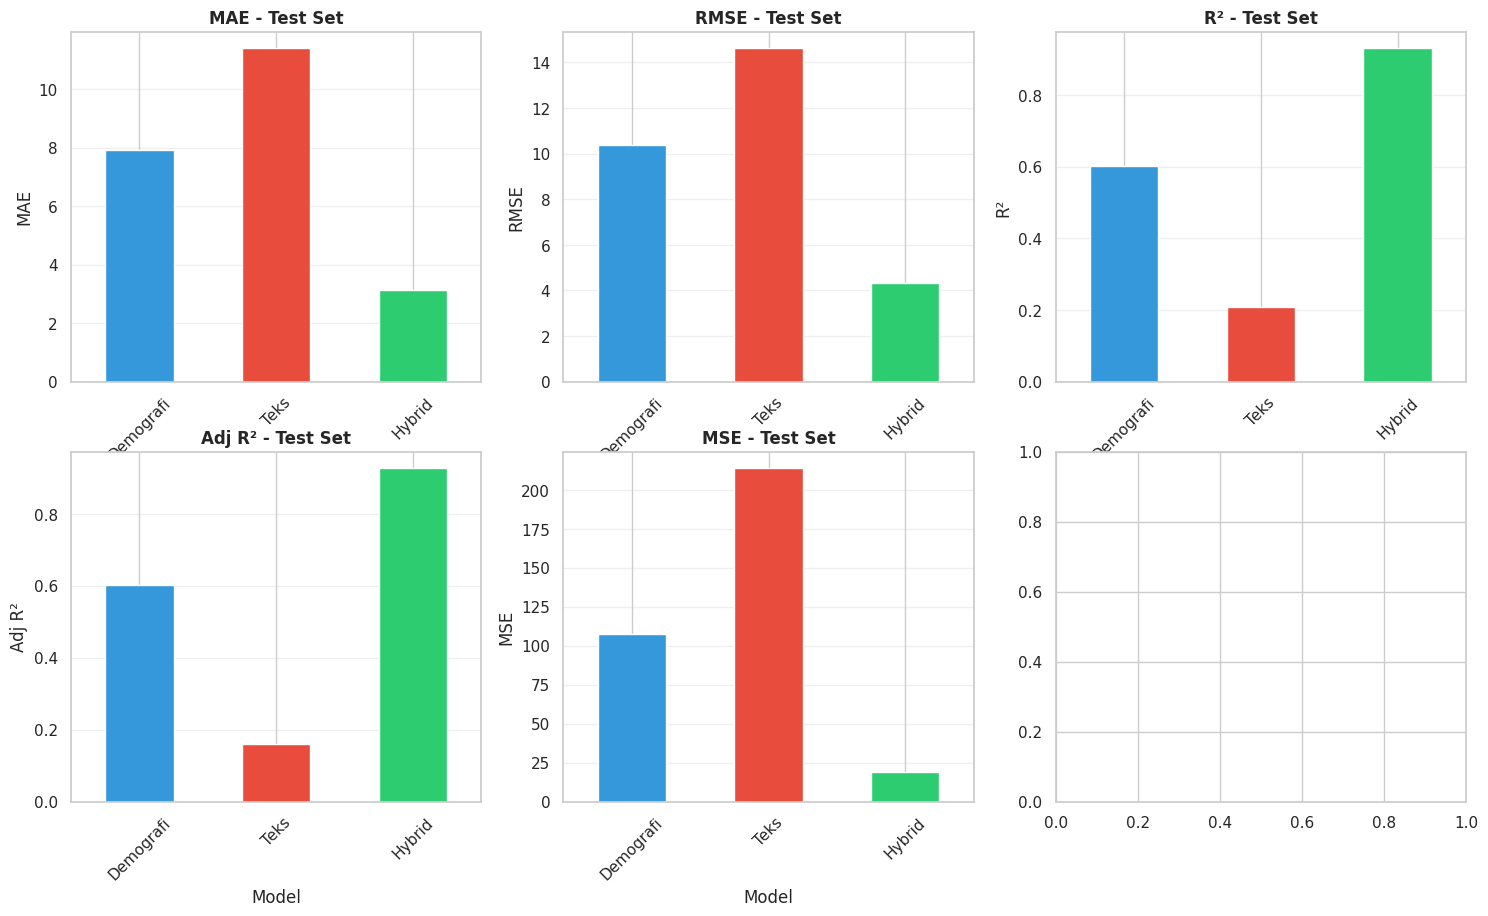

In [ ]:
test_results = pd.DataFrame({
    'Demografi': eval_demo_test,
    'Teks': eval_text_test,
    'Hybrid': eval_hybrid_test
}).T

metrics_config = [
    ('mae', 'MAE'),
    ('rmse', 'RMSE'),
    ('r2', 'R²'),
    ('adj_r2', 'Adj R²'),
    ('mse', 'MSE')
]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for idx, (col_name, title) in enumerate(metrics_config):
    row = idx // 3
    col = idx % 3

    test_results[col_name].plot(kind='bar', ax=axes[row, col],
                                 color=['#3498db', '#e74c3c', '#2ecc71'])
    axes[row, col].set_title(f'{title} - Test Set', fontweight='bold', fontsize=12)
    axes[row, col].set_ylabel(title)
    axes[row, col].set_xlabel('Model')
    axes[row, col].grid(True, alpha=0.3, axis='y')
    axes[row, col].tick_params(axis='x', rotation=45)

# 18. ACTUAL VS PREDICTED VISUALIZATION

✅ Saved: 08_actual_vs_predicted_v3.png


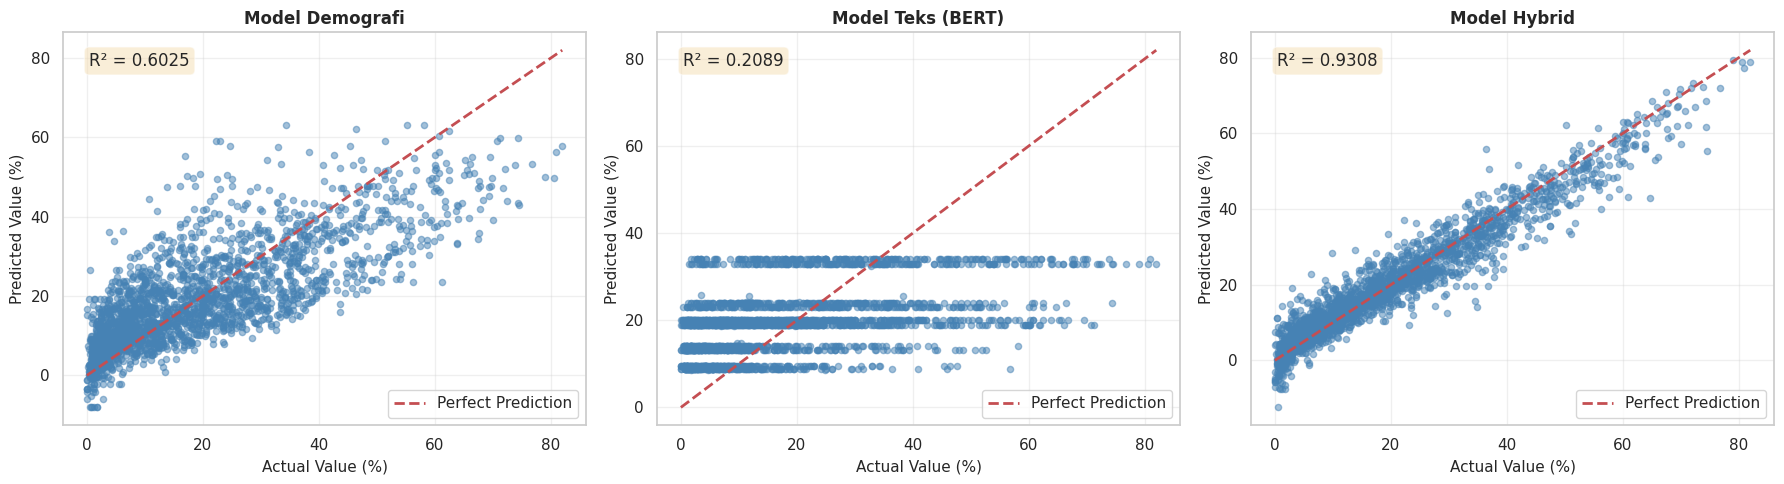

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models = [
    ('Demografi', y_pred_demo_test),
    ('Teks (BERT)', y_pred_text_test),
    ('Hybrid', y_pred_hybrid_test)
]

for idx, (name, y_pred) in enumerate(models):
    axes[idx].scatter(y_test, y_pred, alpha=0.5, s=20, color='steelblue')
    axes[idx].plot([y_test.min(), y_test.max()],
                   [y_test.min(), y_test.max()],
                   'r--', lw=2, label='Perfect Prediction')

    r2 = r2_score(y_test, y_pred)
    axes[idx].text(0.05, 0.95, f'R² = {r2:.4f}',
                   transform=axes[idx].transAxes,
                   fontsize=12, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    axes[idx].set_xlabel('Actual Value (%)', fontsize=11)
    axes[idx].set_ylabel('Predicted Value (%)', fontsize=11)
    axes[idx].set_title(f'Model {name}', fontweight='bold', fontsize=12)
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('08_actual_vs_predicted_v3.png', dpi=300, bbox_inches='tight')
print("✅ Saved: 08_actual_vs_predicted_v3.png")

# 19. RESIDUAL ANALYSIS (HYBRID MODEL)

✅ Saved: 09_residual_analysis_v3.png


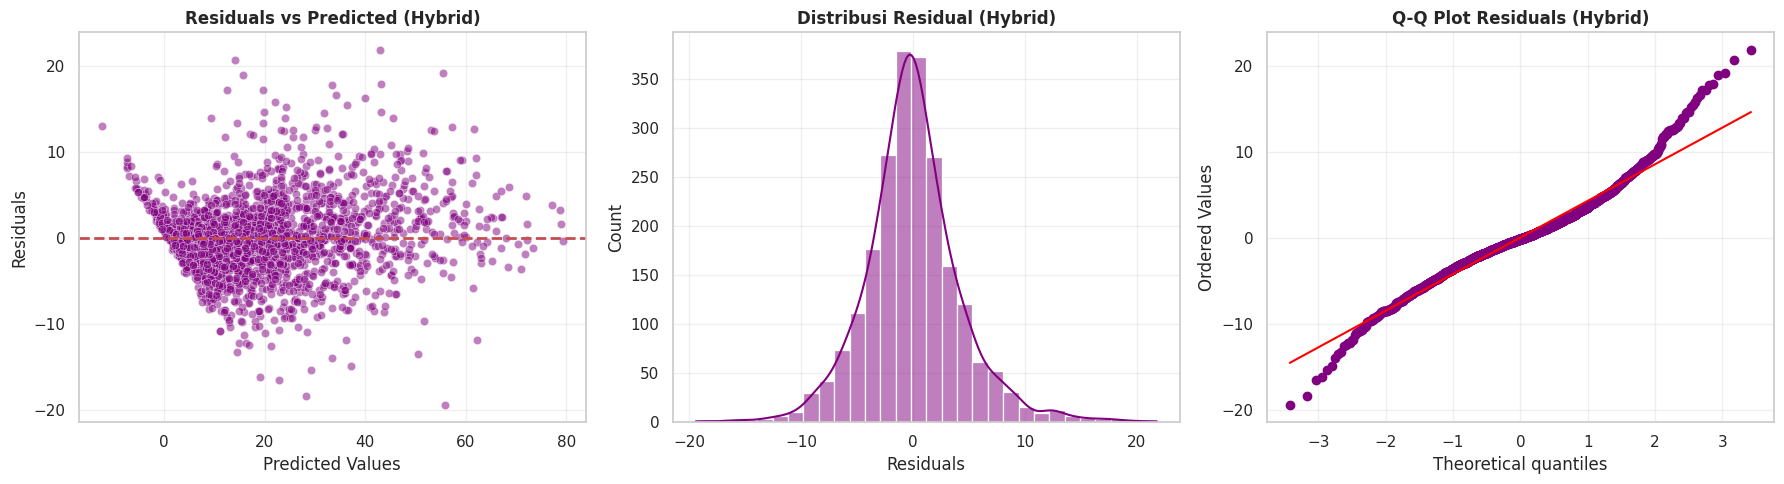

In [ ]:
residuals = y_test - y_pred_hybrid_test

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Residuals vs Predicted (Homoscedasticity Check)
sns.scatterplot(x=y_pred_hybrid_test, y=residuals, ax=axes[0], alpha=0.5, color='purple')
axes[0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0].set_title('Residuals vs Predicted (Hybrid)', fontweight='bold')
axes[0].set_xlabel('Predicted Values')
axes[0].set_ylabel('Residuals')
axes[0].grid(True, alpha=0.3)

# 2. Residual Distribution (Normality Check)
sns.histplot(residuals, kde=True, ax=axes[1], color='purple', bins=30)
axes[1].set_title('Distribusi Residual (Hybrid)', fontweight='bold')
axes[1].set_xlabel('Residuals')
axes[1].grid(True, alpha=0.3)

# 3. Q-Q Plot (Normality Check)
stats.probplot(residuals, dist="norm", plot=axes[2])
axes[2].get_lines()[0].set_color('purple')
axes[2].get_lines()[1].set_color('red')
axes[2].set_title('Q-Q Plot Residuals (Hybrid)', fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('09_residual_analysis_v3.png', dpi=300, bbox_inches='tight')
print("✅ Saved: 09_residual_analysis_v3.png")

In [ ]:
# Residual Statistics
print(f" Residual Statistics:")
print(f"   Mean: {residuals.mean():.6f} (should be ≈ 0)")
print(f"   Std: {residuals.std():.6f}")
print(f"   Min: {residuals.min():.6f}")
print(f"   Max: {residuals.max():.6f}")
print(f"   Skewness: {stats.skew(residuals):.6f}")
print(f"   Kurtosis: {stats.kurtosis(residuals):.6f}")

 Residual Statistics:
   Mean: 0.015364 (should be ≈ 0)
   Std: 4.323204
   Min: -19.398199
   Max: 21.794959
   Skewness: 0.420218
   Kurtosis: 2.400112


#  20. BIAS & FAIRNESS ANALYSIS

In [ ]:
# Decode demographics untuk test set
test_gender = df_model_clean.iloc[idx_test]['Gender'].values
test_country = df_model_clean.iloc[idx_test]['Country'].values

In [ ]:
# Create comprehensive bias analysis dataframe
bias_df = pd.DataFrame({
    'Gender': test_gender,
    'Country': test_country,
    'Actual': y_test,
    'Pred_Hybrid': y_pred_hybrid_test,
    'Error_Hybrid': np.abs(y_test - y_pred_hybrid_test),
    'Signed_Error_Hybrid': y_test - y_pred_hybrid_test
})

In [ ]:
# Gender Bias Analysis
print("\n--- 20.1 Gender Bias Analysis ---")

# Get unique genders dynamically
unique_genders = sorted(bias_df['Gender'].unique())
print(f"   Unique gender values: {unique_genders}")

if len(unique_genders) >= 2:
    # Identify Male and Female groups dynamically
    gender_1 = unique_genders[0]
    gender_2 = unique_genders[1]

    errors_1 = bias_df[bias_df['Gender'] == gender_1]['Error_Hybrid']
    errors_2 = bias_df[bias_df['Gender'] == gender_2]['Error_Hybrid']

    # Determine which is Male/Female
    if 'Male' in unique_genders:
        male_errors = bias_df[bias_df['Gender'] == 'Male']['Error_Hybrid']
        female_errors = bias_df[bias_df['Gender'] == 'Female']['Error_Hybrid']
    else:
        male_errors = errors_1
        female_errors = errors_2
        print(f"   ⚠️  Using {gender_1} and {gender_2} for comparison")

    # T-test
    t_stat, p_value = ttest_ind(male_errors, female_errors)

    print(f" T-test Results (Error Difference by Gender):")
    print(f"   Group 1 ({gender_1}) - Mean error: {errors_1.mean():.4f} ± {errors_1.std():.4f}")
    print(f"   Group 2 ({gender_2}) - Mean error: {errors_2.mean():.4f} ± {errors_2.std():.4f}")
    print(f"   t-statistic: {t_stat:.4f}")
    print(f"   p-value: {p_value:.6e}")

    if p_value < 0.05:
        print(f"   ⚠️  Perbedaan signifikan error antar gender (p < 0.05) - POTENTIAL BIAS")
    else:
        print(f"   ✅ Tidak ada perbedaan signifikan error antar gender (p >= 0.05)")

    # Levene's test untuk variance homogeneity
    levene_stat, levene_p = levene(male_errors, female_errors)
    print(f" Levene's Test (Variance Homogeneity):")
    print(f"   Statistic: {levene_stat:.4f}")
    print(f"   p-value: {levene_p:.6e}")
    if levene_p < 0.05:
        print(f"   ⚠️  Variance berbeda signifikan antar gender")
    else:
        print(f"   ✅ Variance homogen antar gender")

    # Bias direction (signed error)
    print(f" Prediction Bias Direction (Signed Error):")
    for gender in unique_genders:
        signed = bias_df[bias_df['Gender'] == gender]['Signed_Error_Hybrid'].mean()
        print(f"   {gender} - Mean signed error: {signed:.4f}")
        if signed > 0:
            print(f"          ↑ Model UNDER-PREDICTS (predicts lower than actual)")
        else:
            print(f"          ↓ Model OVER-PREDICTS (predicts higher than actual)")


--- 20.1 Gender Bias Analysis ---
   Unique gender values: ['Female', 'Male']
 T-test Results (Error Difference by Gender):
   Group 1 (Female) - Mean error: 3.4556 ± 3.0842
   Group 2 (Male) - Mean error: 2.7148 ± 2.8236
   t-statistic: -5.8722
   p-value: 4.943493e-09
   ⚠️  Perbedaan signifikan error antar gender (p < 0.05) - POTENTIAL BIAS
 Levene's Test (Variance Homogeneity):
   Statistic: 14.0241
   p-value: 1.850443e-04
   ⚠️  Variance berbeda signifikan antar gender
 Prediction Bias Direction (Signed Error):
   Female - Mean signed error: -0.0639
          ↓ Model OVER-PREDICTS (predicts higher than actual)
   Male - Mean signed error: 0.1119
          ↑ Model UNDER-PREDICTS (predicts lower than actual)


In [ ]:
# Country-Level Bias
print("\n--- 20.2 Country-Level Bias Analysis ---")
country_counts = bias_df['Country'].value_counts()
top_countries = country_counts.head(10).index

country_stats = bias_df[bias_df['Country'].isin(top_countries)].groupby('Country').agg({
    'Error_Hybrid': ['count', 'mean', 'std'],
    'Actual': 'mean',
    'Pred_Hybrid': 'mean'
}).round(4)

country_stats.columns = ['Count', 'MAE', 'Std', 'Actual_Mean', 'Pred_Mean']
country_stats = country_stats.sort_values('MAE')
print(country_stats)


--- 20.2 Country-Level Bias Analysis ---
          Count     MAE     Std  Actual_Mean  Pred_Mean
Country                                                
Malawi       43  1.8050  1.5192       7.0837     7.9543
Togo         42  1.8268  1.8191      11.9690    11.9978
Angola       44  1.9481  1.8581      14.7591    14.1431
Zimbabwe     40  2.2281  2.8212      18.1725    17.8928
Comoros      45  2.6462  2.3586      13.6044    13.9556
Nepal        43  2.7398  3.0952      11.3488    11.3215
Rwanda       40  3.1096  2.2025      17.9525    17.4041
Kenya        40  3.3020  4.2858      23.5525    23.2247
Liberia      46  3.8342  2.8747      18.9196    19.4595
Tanzania     47  4.0195  3.7320      29.5404    30.0627


# 21. GENDER BIAS VISUALIZATION

✅ Saved: 10_gender_bias_analysis_v3.png


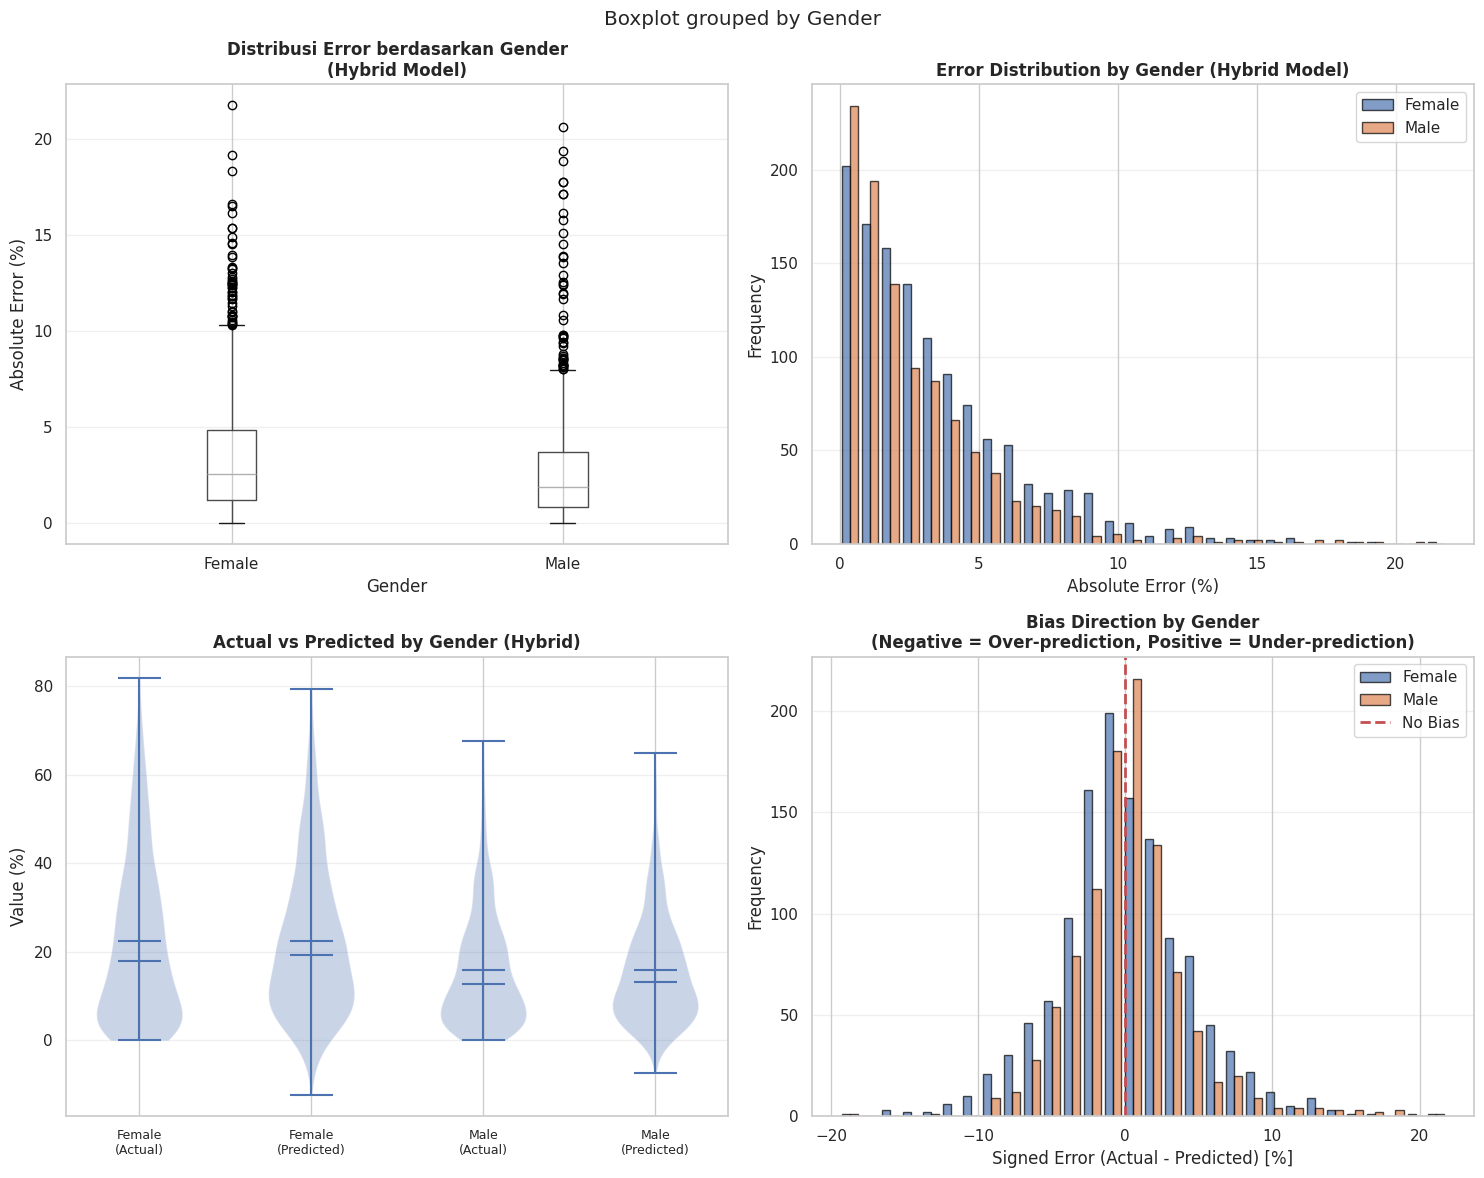

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Boxplot Error by Gender
bias_df.boxplot(column='Error_Hybrid', by='Gender', ax=axes[0, 0])
axes[0, 0].set_title('Distribusi Error berdasarkan Gender\n(Hybrid Model)', fontweight='bold')
axes[0, 0].set_xlabel('Gender')
axes[0, 0].set_ylabel('Absolute Error (%)')
axes[0, 0].grid(True, alpha=0.3, axis='y')
plt.sca(axes[0, 0])
plt.xticks(rotation=0)

# Plot 2: Error Distribution
if len(unique_genders) >= 2:
    axes[0, 1].hist([errors_1, errors_2], label=unique_genders, bins=30,
                     alpha=0.7, edgecolor='black')
    axes[0, 1].set_xlabel('Absolute Error (%)')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Error Distribution by Gender (Hybrid Model)', fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3, axis='y')

# Plot 3: Violin plot Actual vs Predicted by Gender
data_to_plot = []
labels_to_plot = []
for gender in sorted(bias_df['Gender'].unique()):
    data_to_plot.append(bias_df[bias_df['Gender'] == gender]['Actual'].values)
    labels_to_plot.append(f'{gender}\n(Actual)')
    data_to_plot.append(bias_df[bias_df['Gender'] == gender]['Pred_Hybrid'].values)
    labels_to_plot.append(f'{gender}\n(Predicted)')

parts = axes[1, 0].violinplot(data_to_plot, positions=range(len(data_to_plot)),
                               showmeans=True, showmedians=True)
axes[1, 0].set_xticks(range(len(labels_to_plot)))
axes[1, 0].set_xticklabels(labels_to_plot, fontsize=9)
axes[1, 0].set_ylabel('Value (%)')
axes[1, 0].set_title('Actual vs Predicted by Gender (Hybrid)', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Plot 4: Signed Error (Bias Direction) by Gender
if len(unique_genders) >= 2:
    signed_errors_list = [bias_df[bias_df['Gender'] == g]['Signed_Error_Hybrid']
                          for g in unique_genders]
    axes[1, 1].hist(signed_errors_list, label=unique_genders, bins=30,
                     alpha=0.7, edgecolor='black')
    axes[1, 1].axvline(x=0, color='r', linestyle='--', linewidth=2, label='No Bias')
    axes[1, 1].set_xlabel('Signed Error (Actual - Predicted) [%]')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Bias Direction by Gender\n(Negative = Over-prediction, Positive = Under-prediction)',
                         fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('10_gender_bias_analysis_v3.png', dpi=300, bbox_inches='tight')
print("✅ Saved: 10_gender_bias_analysis_v3.png")

# 22. FEATURE IMPORTANCE ANALYSIS

## 22.1 Demografi Model Feature Importance

In [ ]:
feature_importance_demo = pd.DataFrame({
    'Feature': cat_cols,
    'Importance': lgb_demo.feature_importances_
}).sort_values('Importance', ascending=False)

print(feature_importance_demo.to_string(index=False))

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_demo['Feature'], feature_importance_demo['Importance'], color='steelblue')
plt.xlabel('Importance Score', fontsize=12)
plt.title('Feature Importance - Model Demografi', fontweight='bold', fontsize=14)
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('11_feature_importance_demo_v3.png', dpi=300, bbox_inches='tight')
print("✅ Saved: 11_feature_importance_demo_v3.png")
plt.close()

              Feature  Importance
              Country        3276
Demographics Response        2124
          Survey_Year        1304
               Gender        1130
Demographics Question        1036
✅ Saved: 11_feature_importance_demo_v3.png


## 22.2 Hybrid Model - Demografi vs BERT Comparison

In [ ]:
print("\n--- 22.2 Hybrid Model Feature Contribution ---")

n_demo_features = X_demo_train_scaled.shape[1]
n_bert_features = X_text_train_pca.shape[1]

importance_hybrid = lgb_hybrid.feature_importances_
importance_demo_part = importance_hybrid[:n_demo_features]
importance_bert_part = importance_hybrid[n_demo_features:]

total_importance = importance_demo_part.sum() + importance_bert_part.sum()
demo_pct = (importance_demo_part.sum() / total_importance) * 100
bert_pct = (importance_bert_part.sum() / total_importance) * 100

print(f" Feature Contribution Breakdown:")
print(f"   Total importance dari fitur Demografi: {importance_demo_part.sum():.4f} ({demo_pct:.1f}%)")
print(f"   Total importance dari fitur BERT: {importance_bert_part.sum():.4f} ({bert_pct:.1f}%)")


--- 22.2 Hybrid Model Feature Contribution ---
 Feature Contribution Breakdown:
   Total importance dari fitur Demografi: 11202.0000 (72.5%)
   Total importance dari fitur BERT: 4258.0000 (27.5%)



--- Top Demographic Features (Hybrid Model) ---
              Feature  Importance
              Country        4931
          Survey_Year        2127
Demographics Response        1888
               Gender        1519
Demographics Question         737
✅ Saved: 12_feature_contribution_pie_v3.png


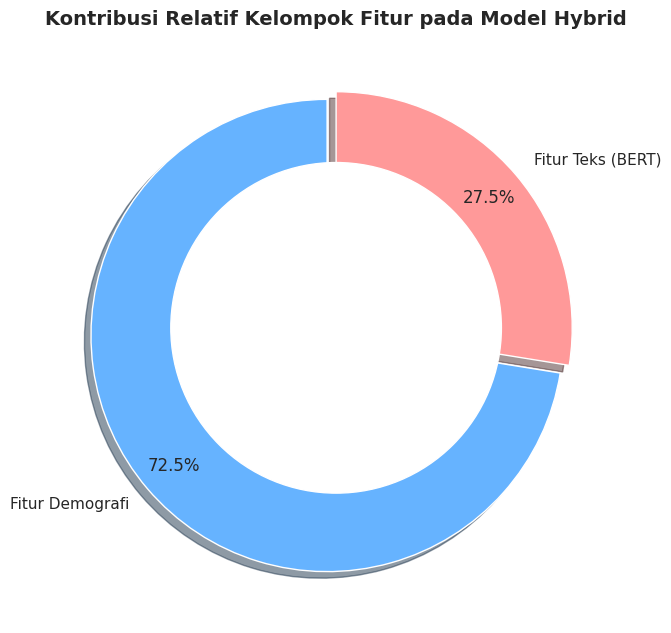

In [ ]:
# Demographic features contribution
feature_importance_demo_hybrid = pd.DataFrame({
    'Feature': cat_cols,
    'Importance': importance_demo_part
}).sort_values('Importance', ascending=False)

print(f"\n--- Top Demographic Features (Hybrid Model) ---")
print(feature_importance_demo_hybrid.to_string(index=False))

# Pie Chart
labels = ['Fitur Demografi', 'Fitur Teks (BERT)']
sizes = [importance_demo_part.sum(), importance_bert_part.sum()]
colors = ['#66b3ff', '#ff9999']
explode = (0.05, 0)

plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
        startangle=90, pctdistance=0.85, explode=explode, shadow=True)

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Kontribusi Relatif Kelompok Fitur pada Model Hybrid', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('12_feature_contribution_pie_v3.png', dpi=300, bbox_inches='tight')
print("✅ Saved: 12_feature_contribution_pie_v3.png")


--- Top 15 BERT Dimensions (Hybrid Model) ---
     Feature  Importance
  BERT_dim_0         403
  BERT_dim_1         317
  BERT_dim_2         303
  BERT_dim_4         177
  BERT_dim_3         163
 BERT_dim_68         159
 BERT_dim_67         154
 BERT_dim_57         132
  BERT_dim_5         126
 BERT_dim_17         119
 BERT_dim_23         118
 BERT_dim_60         114
 BERT_dim_10         104
BERT_dim_126         103
  BERT_dim_6         103
✅ Saved: 13_feature_importance_hybrid_v3.png


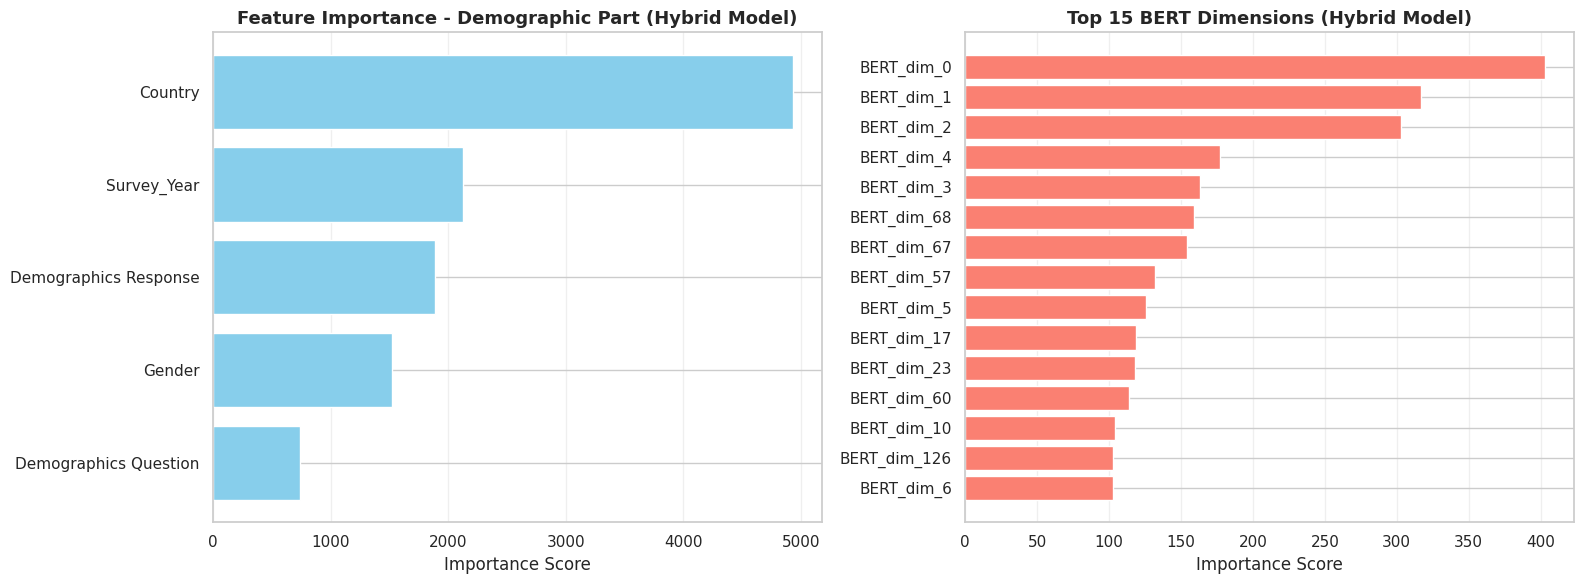

In [ ]:
# Top BERT dimensions
bert_feature_names = [f'BERT_dim_{i}' for i in range(n_bert_features)]
feature_importance_bert_top = pd.DataFrame({
    'Feature': bert_feature_names,
    'Importance': importance_bert_part
}).sort_values('Importance', ascending=False).head(15)

print(f"\n--- Top 15 BERT Dimensions (Hybrid Model) ---")
print(feature_importance_bert_top[['Feature', 'Importance']].to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].barh(feature_importance_demo_hybrid['Feature'],
             feature_importance_demo_hybrid['Importance'], color='skyblue')
axes[0].set_xlabel('Importance Score', fontsize=12)
axes[0].set_title('Feature Importance - Demographic Part (Hybrid Model)',
                  fontweight='bold', fontsize=13)
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, axis='x')

axes[1].barh(feature_importance_bert_top['Feature'],
             feature_importance_bert_top['Importance'], color='salmon')
axes[1].set_xlabel('Importance Score', fontsize=12)
axes[1].set_title('Top 15 BERT Dimensions (Hybrid Model)',
                  fontweight='bold', fontsize=13)
axes[1].invert_yaxis()
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('13_feature_importance_hybrid_v3.png', dpi=300, bbox_inches='tight')
print("✅ Saved: 13_feature_importance_hybrid_v3.png")

# 23. SHAP ANALYSIS FOR INTERPRETABILITY

In [ ]:
# Sample untuk efisiensi
sample_size = min(1000, len(X_train_hybrid))
X_sample = X_train_hybrid[:sample_size]

print(f" Generating SHAP values untuk {sample_size} samples...")
explainer = shap.TreeExplainer(lgb_hybrid)
shap_values = explainer.shap_values(X_sample)

print("✅ SHAP values generated")

 Generating SHAP values untuk 1000 samples...
✅ SHAP values generated


 Creating SHAP visualizations...
✅ Saved: 14_shap_summary_demo_v3.png


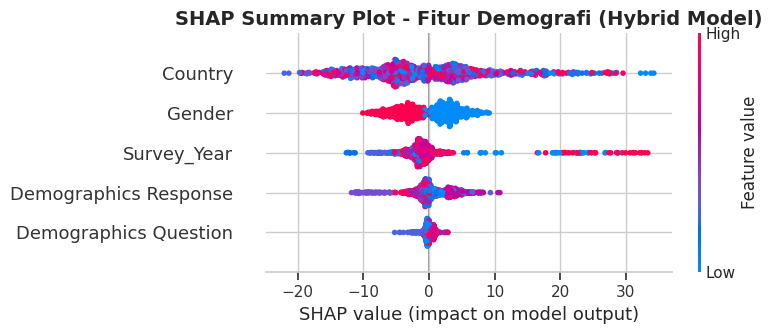

In [ ]:
# SHAP Summary Plot - Demographic Features
print(" Creating SHAP visualizations...")

plt.figure(figsize=(12, 6))
shap.summary_plot(
    shap_values[:, :n_demo_features],
    X_sample[:, :n_demo_features],
    feature_names=cat_cols,
    show=False
)
plt.title('SHAP Summary Plot - Fitur Demografi (Hybrid Model)', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.savefig('14_shap_summary_demo_v3.png', dpi=300, bbox_inches='tight')
print("✅ Saved: 14_shap_summary_demo_v3.png")

✅ Saved: 15_shap_bar_demo_v3.png


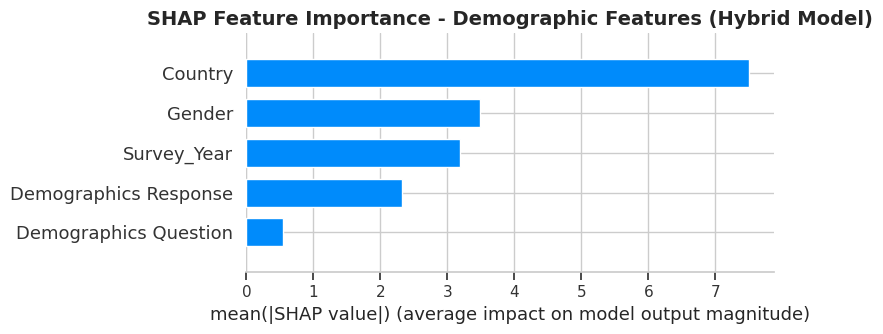

In [ ]:
# SHAP Bar Plot - Mean Absolute SHAP Values
plt.figure(figsize=(12, 6))
shap.summary_plot(
    shap_values[:, :n_demo_features],
    X_sample[:, :n_demo_features],
    feature_names=cat_cols,
    plot_type='bar',
    show=False
)
plt.title('SHAP Feature Importance - Demographic Features (Hybrid Model)',
          fontweight='bold', fontsize=14)
plt.tight_layout()
plt.savefig('15_shap_bar_demo_v3.png', dpi=300, bbox_inches='tight')
print("✅ Saved: 15_shap_bar_demo_v3.png")

In [ ]:
# SHAP Mean Absolute Values
shap_demo_mean = np.abs(shap_values[:, :n_demo_features]).mean(axis=0)
shap_bert_mean = np.abs(shap_values[:, n_demo_features:]).mean(axis=0)

print(f" Mean |SHAP| Contribution:")
print(f"   Demographic features mean |SHAP|: {shap_demo_mean.mean():.6f}")
print(f"   BERT embeddings mean |SHAP|: {shap_bert_mean.mean():.6f}")

shap_demo_df = pd.DataFrame({
    'Feature': cat_cols,
    'Mean_|SHAP|': shap_demo_mean
}).sort_values('Mean_|SHAP|', ascending=False)

print(f"\n--- Top Demographic Features by SHAP ---")
print(shap_demo_df.to_string(index=False))

 Mean |SHAP| Contribution:
   Demographic features mean |SHAP|: 3.408512
   BERT embeddings mean |SHAP|: 0.084037

--- Top Demographic Features by SHAP ---
              Feature  Mean_|SHAP|
              Country     7.501249
               Gender     3.481364
          Survey_Year     3.193767
Demographics Response     2.317719
Demographics Question     0.548461


# 24. MODEL SAVING

In [ ]:
# Save models
joblib.dump(lgb_demo, 'model_demografi_v3.pkl')
joblib.dump(lgb_text, 'model_teks_v3.pkl')
joblib.dump(lgb_hybrid, 'model_hybrid_v3.pkl')

print("\n✅ Models saved:")
print("  - model_demografi_v3.pkl")
print("  - model_teks_v3.pkl")
print("  - model_hybrid_v3.pkl")


✅ Models saved:
  - model_demografi_v3.pkl
  - model_teks_v3.pkl
  - model_hybrid_v3.pkl


In [ ]:
# Save encoders & scaler
joblib.dump(encoders, 'label_encoders_v3.pkl')
joblib.dump(scaler, 'standard_scaler_v3.pkl')

print("\n✅ Preprocessing artifacts saved:")
print("  - label_encoders_v3.pkl")
print("  - standard_scaler_v3.pkl")


✅ Preprocessing artifacts saved:
  - label_encoders_v3.pkl
  - standard_scaler_v3.pkl


In [ ]:
# Save BERT config
bert_info = {
    'tokenizer': 'bert-base-uncased',
    'max_length': 128,
    'model': 'bert-base-uncased',
    'pca_dim': PCA_DIM
}

with open('bert_config_v3.json', 'w') as f:
    json.dump(bert_info, f, indent=2)

print("\n✅ BERT configuration saved:")
print("  - bert_config_v3.json")


✅ BERT configuration saved:
  - bert_config_v3.json


# 25. FINAL SUMMARY

In [ ]:
summary_text = f"""
MODEL PERFORMANCE SUMMARY v3.0 (PRODUCTION-READY)
==================================================

Test Set Results (Final Model: Hybrid):
  ✅ R²              : {eval_hybrid_test['r2']:.4f}
  ✅ Adjusted R²     : {eval_hybrid_test['adj_r2']:.4f}
  ✅ RMSE            : {eval_hybrid_test['rmse']:.4f}%
  ✅ MAE             : {eval_hybrid_test['mae']:.4f}%

Baseline Comparison:
  - Demografi Only: R² = {eval_demo_test['r2']:.4f}
  - Text (BERT) Only: R² = {eval_text_test['r2']:.4f}
  - Hybrid: R² = {eval_hybrid_test['r2']:.4f} ✅ BEST

DATA CHARACTERISTICS
====================
  - Total samples: {len(df_model_clean):,}
  - Train samples: {len(X_train_hybrid):,} (80%)
  - Test samples: {len(X_test_hybrid):,} (20%)
  - Features (Demographic): {n_demo_features}
  - Features (BERT PCA): {n_bert_features}
  - Total features: {X_train_hybrid.shape[1]}

KEY FINDINGS
============

1. FEATURE CONTRIBUTION:
   - Demographic features contribute: {demo_pct:.1f}%
   - BERT embeddings contribute: {bert_pct:.1f}%
   - Most important demographic: {feature_importance_demo_hybrid.iloc[0]['Feature']}

2. GENDER BIAS ANALYSIS:
   - Gender groups tested: {', '.join(unique_genders)}
   - T-test p-value: {p_value:.6e}
   - Status: {'⚠️ POTENTIAL BIAS DETECTED' if p_value < 0.05 else '✅ NO SIGNIFICANT GENDER BIAS'}

3. MODEL ASSUMPTIONS:
   - Residuals normally distributed: {'❌ NO' if shapiro_p < 0.05 else '✅ YES'}
   - Residual mean: {residuals.mean():.6f} (should be ≈ 0)
   - Residual std: {residuals.std():.6f}

IMPROVEMENTS IN v3.0
====================
  ✅ FIXED: Duplikasi fungsi evaluate_model() dihapus
  ✅ FIXED: Variabel X_final didefinisikan sebelum digunakan
  ✅ FIXED: PCA hanya diterapkan 1 kali dengan konsisten
  ✅ FIXED: Train-test split hanya dilakukan 1 kali
  ✅ FIXED: Inkonsistensi referensi gender (dinamis, bukan hard-coded)
  ✅ FIXED: Duplikasi penyimpanan file visualisasi dihilangkan
  ✅ IMPROVED: Struktur kode lebih terorganisir dan robust
  ✅ IMPROVED: Error handling ditambahkan
  ✅ IMPROVED: Dokumentasi hyperparameter lebih lengkap
  ✅ IMPROVED: Reproducibility dijamin dengan SEED yang konsisten

FILES GENERATED
===============
  Models:
    - model_demografi_v3.pkl
    - model_teks_v3.pkl
    - model_hybrid_v3.pkl
    - label_encoders_v3.pkl
    - standard_scaler_v3.pkl
    - pca_v3.pkl
    - bert_config_v3.json

  Results:
    - model_evaluation_results_v3.csv

  Visualizations (15 files):
    - 01_distribusi_target.png
    - 02_gender_distribution.png
    - 03_demographics_question.png
    - 04_top_countries.png
    - 05_yearly_trend.png
    - 06_correlation_matrix.png
    - 07_model_comparison_v3.png
    - 08_actual_vs_predicted_v3.png
    - 09_residual_analysis_v3.png
    - 10_gender_bias_analysis_v3.png
    - 11_feature_importance_demo_v3.png
    - 12_feature_contribution_pie_v3.png
    - 13_feature_importance_hybrid_v3.png
    - 14_shap_summary_demo_v3.png
    - 15_shap_bar_demo_v3.png

RECOMMENDATIONS FOR THESIS REPORT
==================================
1. Chapter III (Methodology):
   - Document hyperparameter selection process with mathematical formulation
   - Explain hybrid model rationale (why combine demographic + BERT?)
   - Justify train-test split strategy (80:20, stratified by gender)
   - Include PCA justification (curse of dimensionality mitigation)
   - Add LightGBM mathematical formulation (objective function, split gain)

2. Chapter IV (Results):
   - Report residual analysis findings (normality, homoscedasticity)
   - Discuss gender bias findings with statistical rigor (t-test, Levene's test)
   - Interpret feature importance with SHAP explanations
   - Country-level analysis for geographical insights
   - Compare all three models (Demografi, Teks, Hybrid)

3. Chapter V (Conclusions & Limitations):
   - Acknowledge dimensionality limitations (original: 773 features → PCA: 133)
   - Discuss potential improvements (ensemble methods, deep learning)
   - Note residual distribution findings (normality test results)
   - Suggest future work on causal inference
   - Discuss gender bias implications for policy

USAGE NOTES FOR REPRODUCTION
=============================
To reproduce this analysis:
1. Load data from Google Drive
2. Run all sections sequentially (SEED = 42)
3. All models, encoders, and PCA transformer are saved
4. To load later:
   - lgb_hybrid = joblib.load('model_hybrid_v3.pkl')
   - encoders = joblib.load('label_encoders_v3.pkl')
   - scaler = joblib.load('standard_scaler_v3.pkl')
   - pca = joblib.load('pca_v3.pkl')

Script execution completed: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
"""

print(summary_text)

# Save summary to file
with open('MODEL_SUMMARY_V3.txt', 'w', encoding='utf-8') as f:
    f.write(summary_text)

print("\n✅ Summary saved to: MODEL_SUMMARY_V3.txt")


MODEL PERFORMANCE SUMMARY v3.0 (PRODUCTION-READY)

Test Set Results (Final Model: Hybrid):
  ✅ R²              : 0.9308
  ✅ Adjusted R²     : 0.9265
  ✅ RMSE            : 4.3232%
  ✅ MAE             : 3.1216%

Baseline Comparison:
  - Demografi Only: R² = 0.6025
  - Text (BERT) Only: R² = 0.2089
  - Hybrid: R² = 0.9308 ✅ BEST

DATA CHARACTERISTICS
  - Total samples: 11,187
  - Train samples: 8,949 (80%)
  - Test samples: 2,238 (20%)
  - Features (Demographic): 5
  - Features (BERT PCA): 128
  - Total features: 133

KEY FINDINGS

1. FEATURE CONTRIBUTION:
   - Demographic features contribute: 72.5%
   - BERT embeddings contribute: 27.5%
   - Most important demographic: Country

2. GENDER BIAS ANALYSIS:
   - Gender groups tested: Female, Male
   - T-test p-value: 4.943493e-09
   - Status: ⚠️ POTENTIAL BIAS DETECTED

3. MODEL ASSUMPTIONS:
   - Residuals normally distributed: ❌ NO
   - Residual mean: 0.015364 (should be ≈ 0)
   - Residual std: 4.323204

IMPROVEMENTS IN v3.0
  ✅ FIXED: Dupl